In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv("myo_raw_glove.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,424,159,433,163,49,92,54,95,1023,1023,1023,1023,1023
1,442,185,495,184,61,99,58,116,1023,1023,1023,1023,1023
2,438,224,495,178,55,108,54,121,1023,1023,1023,1023,1023
3,391,260,553,176,56,97,50,121,1023,1015,1023,1023,1023
4,240,218,383,134,54,99,44,64,0,1015,1018,1023,1023


In [4]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

In [5]:
df = data.copy(deep=True)

<AxesSubplot:>

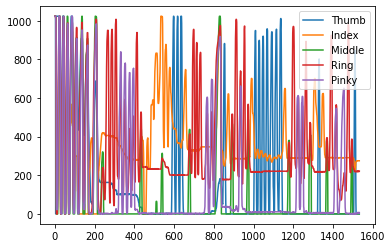

In [6]:
df[finger_names].plot()

<AxesSubplot:>

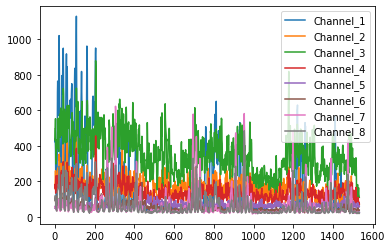

In [7]:
df[myo_cols].plot()

In [8]:
print("Correlation Matrix")
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Correlation Matrix

Top Absolute Correlations
Channel_1  Channel_8    0.754583
Channel_7  Channel_8    0.726021
Channel_3  Channel_4    0.710998
Middle     Pinky        0.708324
Channel_6  Channel_7    0.673336
Channel_8  Ring         0.660545
Channel_1  Pinky        0.628341
Middle     Ring         0.625581
Channel_2  Channel_3    0.607180
Channel_6  Channel_8    0.591596
dtype: float64


# Making a full hand baseline

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 284.666439
Train MAE: 223.888650
Test RMSE: 268.673475
Test MAE: 213.591703


-0.2556959378685044

In [10]:
X

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,424,159,433,163,49,92,54,95
1,442,185,495,184,61,99,58,116
2,438,224,495,178,55,108,54,121
3,391,260,553,176,56,97,50,121
4,240,218,383,134,54,99,44,64
...,...,...,...,...,...,...,...,...
1528,24,77,165,79,55,38,23,20
1529,22,77,162,85,52,34,22,25
1530,25,66,127,78,56,38,23,21
1531,26,60,120,67,65,39,25,19


In [11]:
y

,Thumb,Index,Middle,Ring,Pinky
0,1023,1023,1023,1023,1023
1,1023,1023,1023,1023,1023
2,1023,1023,1023,1023,1023
3,1023,1015,1023,1023,1023
4,0,1015,1018,1023,1023
...,...,...,...,...,...
1528,0,275,0,221,7
1529,0,275,0,221,3
1530,0,275,0,221,7
1531,0,275,0,219,3


# Making a baseline Neural Network

In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [13]:
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = abs(df[x_cols])
y = df.drop(x_cols,1)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
# Fit the scaler on the training set.
train_X = emg_scaler.fit_transform(train_X)
train_y = rel_hand_scaler.fit_transform(train_y)
# Scale the output data.
test_X = emg_scaler.transform(test_X)
test_y = rel_hand_scaler.transform(test_y)

In [14]:
model = Sequential()

# The Input Layer :
model.add(Dense(16,input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))

# The Output Layer :
model.add(Dense(5,activation='linear'))

# Compile the network :
model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 3,125
Trainable params: 3,125
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/200
36/36 [==============================] - 13s 12ms/step - loss: 0.9520 - val_loss: 0.8942
Epoch 2/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7028 - val_loss: 0.7642
Epoch 3/200
36/36 [==============================] - 0s 3ms/step - loss: 0.6966 - val_loss: 0.7124
Epoch 4/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7359 - val_loss: 0.6898
Epoch 5/200
36/36 [==============================] - 0s 3ms/step - loss: 0.6690 - val_loss: 0.6748
Epoch 6/200
36/36 [==============================] - 0s 3ms/step - loss: 0.6240 - val_loss: 0.6592
Epoch 7/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5595 - val_loss: 0.6508
Epoch 8/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5811 - val_loss: 0.6446
Epoch 9/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5268 - val_loss: 0.6333
Epoch 10/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5747 - val_loss: 0.6275
Epoch 1

Epoch 83/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3376 - val_loss: 0.5518
Epoch 84/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3244 - val_loss: 0.5584
Epoch 85/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3732 - val_loss: 0.5492
Epoch 86/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3448 - val_loss: 0.5419
Epoch 87/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3082 - val_loss: 0.5500
Epoch 88/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3268 - val_loss: 0.5479
Epoch 89/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3047 - val_loss: 0.5542
Epoch 90/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3311 - val_loss: 0.5526
Epoch 91/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3233 - val_loss: 0.5529
Epoch 92/200
36/36 [==============================] - 0s 3ms/step - loss: 0.3058 - val_loss: 0.5502


36/36 [==============================] - 0s 3ms/step - loss: 0.2814 - val_loss: 0.5770
Epoch 165/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2698 - val_loss: 0.5828
Epoch 166/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2701 - val_loss: 0.5780
Epoch 167/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2623 - val_loss: 0.5858
Epoch 168/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2584 - val_loss: 0.5853
Epoch 169/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2452 - val_loss: 0.5900
Epoch 170/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2426 - val_loss: 0.5943
Epoch 171/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2539 - val_loss: 0.5861
Epoch 172/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2540 - val_loss: 0.5822
Epoch 173/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2641 - val_loss: 0.5763
Epoc

In [16]:
# Evaluate the model on the test data
mse = model.evaluate(test_X, test_y)
mse

12/12 [==============================] - 0s 1ms/step - loss: 0.5792


0.5792431235313416

Note that using wrist as the rel_point gives 0.10, which was a lower loss than using the palm

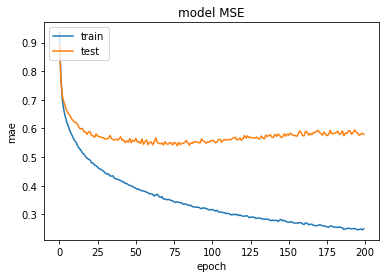

In [17]:
# summarize history for loss
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
prediction = model.predict(train_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[ 0.09443912 -1.0474964  -0.0364555  -0.0625522   0.269404  ]
 [ 0.76914746  0.26363307 -0.3829903  -0.49399045 -0.57610404]
 [-0.07305208  1.0490466  -0.03064599 -0.4039372  -0.6049746 ]
 ...
 [-0.93072426 -0.03300853 -0.4173057   0.21637961  1.2511395 ]
 [ 0.41122648 -1.0951784   0.01500319 -0.34258178  0.24497955]
 [ 0.44827828  0.32370102 -0.2802136  -0.5442444  -0.59459627]]
MSE:  15434.402110983181
RMSE:  124.23526919109236
MAE:  80.32194449551164


In [19]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-3.0142072e-01  1.2373249e-01 -3.5089096e-01 -4.6466449e-01
  -2.4596761e-01]
 [ 7.0862710e-01 -7.4821478e-01  1.4883140e+00  1.4811875e+00
   1.7836396e+00]
 [ 1.3201816e+00 -1.8978601e+00  6.0495722e-01 -1.3400939e-01
   4.7987974e-01]
 ...
 [ 4.4388492e-03 -1.9530492e-01 -3.6341631e-01  2.0914935e-03
   7.1334374e-01]
 [ 8.5128176e-01  2.5689620e-01  7.8208202e-01  1.0242727e-02
   8.1026709e-01]
 [-9.0520716e-01  1.4710425e-01 -4.3587965e-01  2.2779109e+00
  -4.7273493e-01]]
MSE:  37303.58841238948
RMSE:  193.1413689823842
MAE:  123.2548500541714


# Plot the predicted vs ground truth

### Save the model and the scalers

In [20]:
import joblib

model_name = "NNRel-StanScaled"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/NNRel-StanScaled-EMG.gz']

In [21]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"../models/{model_name}.h5")

input_scaler = joblib.load(f'../models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'../models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred

array([[ 598.7148  ,  166.35555 ,  -29.672081,  163.60081 , -171.95096 ]],
      dtype=float32)

In [22]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-3.0142072e-01  1.2373249e-01 -3.5089096e-01 -4.6466449e-01
  -2.4596761e-01]
 [ 7.0862710e-01 -7.4821478e-01  1.4883140e+00  1.4811875e+00
   1.7836396e+00]
 [ 1.3201816e+00 -1.8978601e+00  6.0495722e-01 -1.3400939e-01
   4.7987974e-01]
 ...
 [ 4.4388492e-03 -1.9530492e-01 -3.6341631e-01  2.0914935e-03
   7.1334374e-01]
 [ 8.5128176e-01  2.5689620e-01  7.8208202e-01  1.0242727e-02
   8.1026709e-01]
 [-9.0520716e-01  1.4710425e-01 -4.3587965e-01  2.2779109e+00
  -4.7273493e-01]]
MSE:  37303.58841238948
RMSE:  193.1413689823842
MAE:  123.2548500541714


# LSTMs

In [23]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import LSTM

In [24]:
y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df[y_cols]
X = df[x_cols]

In [25]:
def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X)

In [26]:
Xs.shape

(1532, 16)

In [29]:
rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]
timesteps = 2

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

In [30]:
ny.shape, nX.shape

((1532, 5), (1532, 8, 2))

In [31]:
ny

array([[ 2.7356915 ,  3.6067936 ,  3.6598547 ,  2.538894  ,  3.1850438 ],
       [ 2.7356915 ,  3.6067936 ,  3.6598547 ,  2.538894  ,  3.1850438 ],
       [ 2.7356915 ,  3.5635045 ,  3.6598547 ,  2.538894  ,  3.1850438 ],
       ...,
       [-0.6052938 , -0.44073772, -0.40078467, -0.5037904 , -0.5000219 ],
       [-0.6052938 , -0.44073772, -0.40078467, -0.5113781 , -0.51453   ],
       [-0.6052938 , -0.44073772, -0.40078467, -0.5037904 , -0.5000219 ]],
      dtype=float32)

In [32]:
rel_hand_scaler.transform(y)

array([[ 2.73569146,  3.6067936 ,  3.65985463,  2.5388939 ,  3.18504381],
       [ 2.73569146,  3.6067936 ,  3.65985463,  2.5388939 ,  3.18504381],
       [ 2.73569146,  3.6067936 ,  3.65985463,  2.5388939 ,  3.18504381],
       ...,
       [-0.60529379, -0.44073773, -0.40078468, -0.50379039, -0.50002189],
       [-0.60529379, -0.44073773, -0.40078468, -0.51137813, -0.51453003],
       [-0.60529379, -0.44073773, -0.40078468, -0.50379039, -0.50002189]])

In [33]:
y.head()

,Thumb,Index,Middle,Ring,Pinky
0,1023,1023,1023,1023,1023
1,1023,1023,1023,1023,1023
2,1023,1023,1023,1023,1023
3,1023,1015,1023,1023,1023
4,0,1015,1018,1023,1023


In [34]:
Xs

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_1_p1,Channel_2_p1,Channel_3_p1,Channel_4_p1,Channel_5_p1,Channel_6_p1,Channel_7_p1,Channel_8_p1
1,442.0,185.0,495.0,184.0,61.0,99.0,58.0,116.0,424.0,159.0,433.0,163.0,49.0,92.0,54.0,95.0
2,438.0,224.0,495.0,178.0,55.0,108.0,54.0,121.0,442.0,185.0,495.0,184.0,61.0,99.0,58.0,116.0
3,391.0,260.0,553.0,176.0,56.0,97.0,50.0,121.0,438.0,224.0,495.0,178.0,55.0,108.0,54.0,121.0
4,240.0,218.0,383.0,134.0,54.0,99.0,44.0,64.0,391.0,260.0,553.0,176.0,56.0,97.0,50.0,121.0
5,190.0,178.0,367.0,211.0,70.0,83.0,42.0,49.0,240.0,218.0,383.0,134.0,54.0,99.0,44.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,24.0,77.0,165.0,79.0,55.0,38.0,23.0,20.0,26.0,66.0,137.0,109.0,67.0,43.0,23.0,25.0
1529,22.0,77.0,162.0,85.0,52.0,34.0,22.0,25.0,24.0,77.0,165.0,79.0,55.0,38.0,23.0,20.0
1530,25.0,66.0,127.0,78.0,56.0,38.0,23.0,21.0,22.0,77.0,162.0,85.0,52.0,34.0,22.0,25.0
1531,26.0,60.0,120.0,67.0,65.0,39.0,25.0,19.0,25.0,66.0,127.0,78.0,56.0,38.0,23.0,21.0


In [35]:
df.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,424,159,433,163,49,92,54,95,1023,1023,1023,1023,1023
1,442,185,495,184,61,99,58,116,1023,1023,1023,1023,1023
2,438,224,495,178,55,108,54,121,1023,1023,1023,1023,1023
3,391,260,553,176,56,97,50,121,1023,1015,1023,1023,1023
4,240,218,383,134,54,99,44,64,0,1015,1018,1023,1023


In [36]:
train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [37]:
train_X.shape, train_y.shape

((1032, 8, 2), (1032, 5))

## Simple RNN Arc

In [38]:
model = Sequential()
# 8 Features and 2 timesteps
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))

model.compile(loss='mse', optimizer='adam')

In [39]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
15/15 - 5s - loss: 0.6023 - val_loss: 1.5297
Epoch 2/50
15/15 - 0s - loss: 0.5693 - val_loss: 1.5353
Epoch 3/50
15/15 - 0s - loss: 0.5531 - val_loss: 1.5971
Epoch 4/50
15/15 - 0s - loss: 0.5394 - val_loss: 1.6664
Epoch 5/50
15/15 - 0s - loss: 0.5280 - val_loss: 1.7198
Epoch 6/50
15/15 - 0s - loss: 0.5182 - val_loss: 1.7605
Epoch 7/50
15/15 - 0s - loss: 0.5096 - val_loss: 1.7839
Epoch 8/50
15/15 - 0s - loss: 0.5021 - val_loss: 1.7906
Epoch 9/50
15/15 - 0s - loss: 0.4958 - val_loss: 1.7875
Epoch 10/50
15/15 - 0s - loss: 0.4906 - val_loss: 1.7742
Epoch 11/50
15/15 - 0s - loss: 0.4862 - val_loss: 1.7523
Epoch 12/50
15/15 - 0s - loss: 0.4825 - val_loss: 1.7285
Epoch 13/50
15/15 - 0s - loss: 0.4791 - val_loss: 1.7073
Epoch 14/50
15/15 - 0s - loss: 0.4761 - val_loss: 1.6898
Epoch 15/50
15/15 - 0s - loss: 0.4735 - val_loss: 1.6754
Epoch 16/50
15/15 - 0s - loss: 0.4710 - val_loss: 1.6636
Epoch 17/50
15/15 - 0s - loss: 0.4687 - val_loss: 1.6538
Epoch 18/50
15/15 - 0s - loss: 0.4666 - 

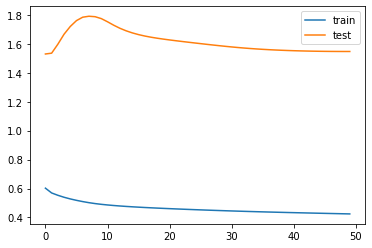

In [40]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [42]:
mse = model.evaluate(test_X, test_y)
mse

16/16 [==============================] - 0s 2ms/step - loss: 1.5470


1.5470212697982788

## Longer Timesequence RNN

In [48]:
data = pd.read_csv("myo_raw_glove.csv")

y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


# Get rid of the [1,2,3,4,5]s from then the labeller was breaking
df = df.iloc[90:]

# Rectify by taking the absolute value
df[x_cols] = abs(df[x_cols])

X = df[x_cols]
y = df[y_cols]

# Scaling
rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

timesteps = 20

def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X, timesteps)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [49]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(14))
model.add(Dense(5))

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8, 64)             21760     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 14)                462       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                

In [52]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), shuffle=True)

Epoch 1/500
11/11 [==============================] - 0s 11ms/step - loss: 0.1431 - val_loss: 0.8173
Epoch 2/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1383 - val_loss: 0.7265
Epoch 3/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1381 - val_loss: 0.8067
Epoch 4/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1361 - val_loss: 0.7480
Epoch 5/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1307 - val_loss: 0.8099
Epoch 6/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1333 - val_loss: 0.7229
Epoch 7/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1286 - val_loss: 0.7529
Epoch 8/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1326 - val_loss: 0.6965
Epoch 9/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1330 - val_loss: 0.8252
Epoch 10/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1242 - val_loss: 0.7274
Epoch 11

Epoch 83/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0866 - val_loss: 0.7874
Epoch 84/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0736 - val_loss: 0.7902
Epoch 85/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0870 - val_loss: 0.7972
Epoch 86/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0907 - val_loss: 0.7373
Epoch 87/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0841 - val_loss: 0.7753
Epoch 88/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0853 - val_loss: 0.7816
Epoch 89/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0856 - val_loss: 0.7564
Epoch 90/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0820 - val_loss: 0.8274
Epoch 91/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0881 - val_loss: 0.7862
Epoch 92/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0871 - val_loss: 0.7696


11/11 [==============================] - 0s 9ms/step - loss: 0.0802 - val_loss: 0.7558
Epoch 165/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0794 - val_loss: 0.7844
Epoch 166/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0755 - val_loss: 0.8120
Epoch 167/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0751 - val_loss: 0.8031
Epoch 168/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0723 - val_loss: 0.7324
Epoch 169/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0811 - val_loss: 0.8952
Epoch 170/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0812 - val_loss: 0.7613
Epoch 171/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0810 - val_loss: 0.7980
Epoch 172/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0827 - val_loss: 0.7598
Epoch 173/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0841 - val_loss: 0.6942
Epoc

11/11 [==============================] - 0s 9ms/step - loss: 0.0719 - val_loss: 0.8336
Epoch 246/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0733 - val_loss: 0.7329
Epoch 247/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0719 - val_loss: 0.7381
Epoch 248/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0828 - val_loss: 0.9076
Epoch 249/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0718 - val_loss: 0.7623
Epoch 250/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0808 - val_loss: 0.8344
Epoch 251/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0781 - val_loss: 0.8080
Epoch 252/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0829 - val_loss: 0.8298
Epoch 253/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0739 - val_loss: 0.7495
Epoch 254/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0776 - val_loss: 0.8323
Epoc

11/11 [==============================] - 0s 9ms/step - loss: 0.0773 - val_loss: 0.9552
Epoch 327/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0807 - val_loss: 0.7075
Epoch 328/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0805 - val_loss: 0.7412
Epoch 329/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0748 - val_loss: 0.7951
Epoch 330/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0706 - val_loss: 0.7766
Epoch 331/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0764 - val_loss: 0.7551
Epoch 332/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0788 - val_loss: 0.8370
Epoch 333/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0690 - val_loss: 0.7710
Epoch 334/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0711 - val_loss: 0.7657
Epoch 335/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0757 - val_loss: 0.7717
Epoc

11/11 [==============================] - 0s 9ms/step - loss: 0.0737 - val_loss: 0.7987
Epoch 408/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0749 - val_loss: 0.8644
Epoch 409/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0713 - val_loss: 0.7828
Epoch 410/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0773 - val_loss: 0.7420
Epoch 411/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0743 - val_loss: 0.7835
Epoch 412/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0769 - val_loss: 0.8152
Epoch 413/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0844 - val_loss: 0.7733
Epoch 414/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0722 - val_loss: 0.9000
Epoch 415/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0720 - val_loss: 0.7698
Epoch 416/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0722 - val_loss: 0.8347
Epoc

11/11 [==============================] - 0s 9ms/step - loss: 0.0717 - val_loss: 0.8542
Epoch 489/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0748 - val_loss: 0.8885
Epoch 490/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0732 - val_loss: 0.7914
Epoch 491/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0705 - val_loss: 0.8137
Epoch 492/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0719 - val_loss: 0.8065
Epoch 493/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0820 - val_loss: 0.7994
Epoch 494/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0763 - val_loss: 0.8516
Epoch 495/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0725 - val_loss: 0.7885
Epoch 496/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0737 - val_loss: 0.9032
Epoch 497/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0672 - val_loss: 0.8388
Epoc

16/16 [==============================] - 0s 3ms/step - loss: 0.7757


0.775662899017334

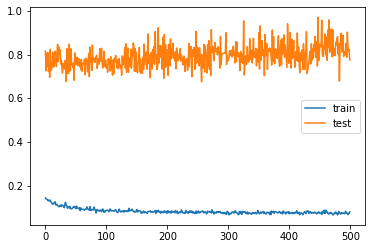

In [53]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mse = model.evaluate(test_X, test_y)
mse


In [55]:
def get_metrics(model, y_scaler, scaled_X, scaled_y):# Training Metrics
    prediction = model.predict(scaled_X) # scaled inputs here

    # Scaling back the prediction
    preds = y_scaler.inverse_transform(prediction)
    # Scaling back the goals
    goal = y_scaler.inverse_transform(scaled_y)

    MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
    print("MSE: ", MSE)
    print("RMSE: ", np.sqrt(MSE))  # 3rd step
    MAE = mean_absolute_error(goal, preds)
    print("MAE: ", MAE)

In [57]:
print("Train:")
get_metrics(model, rel_hand_scaler, train_X, train_y)
print("\nTest:")
get_metrics(model, rel_hand_scaler, test_X, test_y)

Train:
MSE:  762.9766
RMSE:  27.622032
MAE:  14.878973

Test:
MSE:  25952.637
RMSE:  161.09822
MAE:  94.10948


## Plot of predicted vs truth

In [60]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = rel_hand_scaler.inverse_transform(train_preds)
# Scaling back the goals
train_goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = rel_hand_scaler.inverse_transform(test_preds)
# Scaling back the goals
test_goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

train_preds_df = pd.DataFrame(train_preds, columns=y_cols)
train_goals_df = pd.DataFrame(train_goal, columns=y_cols)

Train MSE:  762.9766
Train RMSE:  27.622032
Train MAE:  14.878973

Test MSE:  25952.637
Test RMSE:  161.09822
Test MAE:  94.10948


In [61]:
y_cols_pred = []
for i in y_cols:
    y_cols_pred.append(i+"_pred")
    
preds = pd.DataFrame(train_preds, columns=y_cols_pred)
goal = pd.DataFrame(train_goal, columns=y_cols)
vis = pd.concat([preds, goal], axis=1)

<AxesSubplot:>

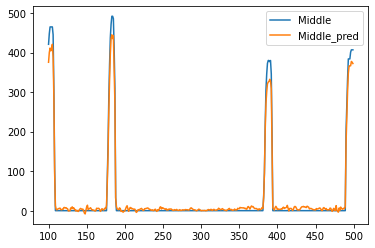

In [64]:
vis[['Middle','Middle_pred']].iloc[100:500].plot()

In [65]:
import joblib

model_name = "LSTMBasic-SEQ-20"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/LSTMBasic-SEQ-20-EMG.gz']

# Simple RNN

In [44]:
from keras.layers import SimpleRNN

In [45]:
df = pd.read_csv("glove_emg1.csv")

y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


# Get rid of the [1,2,3,4,5]s from then the labeller was breaking
df = df.iloc[90:]

# Rectify by taking the absolute value
df[x_cols] = abs(df[x_cols])

# Scale values
df[x_cols] = df[x_cols] / 128
df[y_cols] = df[y_cols] / 1024

timesteps = 20

X = df[x_cols]
y = df[y_cols]

def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X, timesteps)

nX = Xs.values
ny = y.values

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [46]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(SimpleRNN(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(14))
model.add(Dense(5))

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8, 64)             5440      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 14)                462       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

In [47]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=True)

Epoch 1/50
27/27 [==============================] - 7s 49ms/step - loss: 0.2641 - val_loss: 0.2452
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 0.1075 - val_loss: 0.2355
Epoch 3/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0827 - val_loss: 0.2336
Epoch 4/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0784 - val_loss: 0.2266
Epoch 5/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0744 - val_loss: 0.2337
Epoch 6/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0707 - val_loss: 0.2222
Epoch 7/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0685 - val_loss: 0.2198
Epoch 8/50
27/27 [==============================] - 1s 24ms/step - loss: 0.0687 - val_loss: 0.2156
Epoch 9/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0692 - val_loss: 0.2220
Epoch 10/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0635 - val_loss: 0.2111
Epoch 11/

16/16 [==============================] - 0s 4ms/step - loss: 0.2305


0.2305465191602707

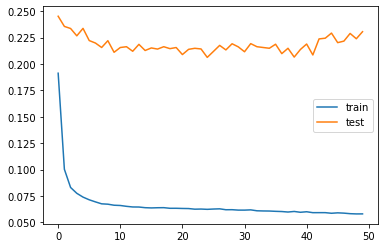

In [48]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mse = model.evaluate(test_X, test_y)
mse

In [49]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = train_preds * 1024
# Scaling back the goals
train_goal = train_y * 1024

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = test_preds * 1024
# Scaling back the goals
test_goal = test_y * 1024

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

Train MSE:  58628.78
Train RMSE:  242.1338
Train MAE:  175.85435

Test MSE:  241745.53
Test RMSE:  491.67624
Test MAE:  382.79385
